# Project Oxford: Computer Vision API example

### This Jupyter notebook shows you how to get started with the Project Oxford <b>Computer Vision API</b> in Python, and how to visualize your results.

To use this notebook, you will need to get keys to <b>Computer Vision API</b>. Visit <a href="https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision">https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision</a>, and then the “Try Computer Vision API” button. On the “Sign in” page, use your Microsoft account to sign in and you will be able to subscribe to Computer Vision API and get free keys (Code of Conduct and TOS). After completing the sign-up process, paste your API key and API region into the variables section below. (Either the primary or the secondary key works.)

In [39]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function
import json
import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas_ml
from pandas_ml import ConfusionMatrix

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [40]:
# Variables
_region = 'southcentralus' #Here you enter the region of your subscription
_url = 'https://{}.api.cognitive.microsoft.com/customvision/v1.0/Prediction/dfe8d889-9861-4355-bd9a-866aa1de21a8/image'.format(_region)
_key = "8b215270f4a74852a876366b55fa33ca"
_maxNumRetries = 10

vrParmsFile = '/Users/lkrishna/git/wdcutils/example_VR_parms.json'
parms = ''
with open(vrParmsFile) as parmFile:
    parms = json.load(parmFile)
base_folder=parms['base_folder']
test_csv_file=parms['test_csv_file']
results_csv_file=parms['results_csv_file']
confmatrix_csv_file=parms['confmatrix_csv_file']

## Helper functions

In [30]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

In [31]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    print (result)
    R = int(result['color']['accentColor'][:2],16)
    G = int(result['color']['accentColor'][2:4],16)
    B = int(result['color']['accentColor'][4:],16)

    cv2.rectangle( img,(0,0), (img.shape[1], img.shape[0]), color = (R,G,B), thickness = 25 )

    if 'categories' in result:
        categoryName = sorted(result['categories'], key=lambda x: x['score'])[0]['name']
        cv2.putText( img, categoryName, (30,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3 )

In [32]:
# Process multiple images (provided via csv file) in batch. Effectively, read the csv file and for each image
# utterance, get VR response. Aggregate and return results.
def processBatchRequest(csvfile):
    test_classes=[]
    vr_predict_classes=[]
    vr_predict_confidence=[]
    images=[]
    i=0

    # Computer Vision parameters
    params = { 'visualFeatures' : 'Color,Categories'} 

    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _key
    headers['Content-Type'] = 'application/octet-stream'
    headers['Prediction-Key'] = _key

    json = None
    data = None
    
    with open(csvfile, 'rb') as csvfile:
        csvReader=csv.DictReader(csvfile)
        for row in csvReader:
            test_classes.append(row['class'])
            
            pathToImageFile = row['image']
            with open( pathToImageFile, 'rb' ) as f:
                data = f.read()
            result = processRequest(json, data, headers, params)
            topClass = result['Predictions'][0]['Tag']
            topConfidence = result['Predictions'][0]['Probability']
            vr_predict_classes.append(topClass)
            vr_predict_confidence.append(topConfidence)
            images.append(row['image'])
            i = i+1
            if(i%250 == 0):
                print ("Processed ", i, " records")
        print ("Finished processing ", i, " records")      
    return test_classes, vr_predict_classes,vr_predict_confidence, images

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()
    

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'wb') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)

## Analysis of an image retrieved via URL

In [6]:
# URL direction to image
urlImage = 'https://oxfordportal.blob.core.windows.net/vision/Analysis/3.jpg'

# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json'

json = { 'url': urlImage } 
data = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    #ig, ax = plt.subplots(figsize=(15, 20))
    #ax.imshow( img )
    print ("Top Tag : " + result['Predictions'][0]['Tag'])
    print ("Top Tag Probability: " , result['Predictions'][0]['Probability'])       

Error code: 401
Message: {'statusCode': 401, 'message': 'Access denied due to missing subscription key. Make sure to include subscription key when making requests to an API.'}


## Analysis of an image stored on disk

Top Tag : usb_male
Top Tag Probability:  0.8388815


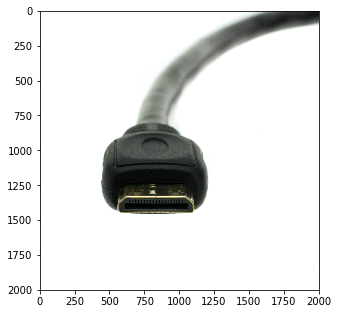

In [35]:
# Load raw image file into memory
pathToFileInDisk = r'/Users/lkrishna/git/pluto-vision/etc/test/connectors/10v3-431xx_05.jpg'
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()
    
# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories,Tags'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'
headers['Prediction-Key'] = _key

json = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
    
    #renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(5, 10))
    ax.imshow( img )
    print ("Top Tag : " + result['Predictions'][0]['Tag'])
    print ("Top Tag Probability: " , result['Predictions'][0]['Probability'])

In [36]:
test_classes,vr_predict_classes,vr_predict_conf,images=processBatchRequest(test_csv_file)

Error: iterator should return strings, not bytes (did you open the file in text mode?)

In [119]:
# print results to csv file including original text, the correct label, 
# the predicted label and the confidence reported by NLC.
csvfileOut=results_csv_file
with open(csvfileOut, 'wb') as csvOut:
    outrow=['image','true class','VR Predicted class','Confidence']
    csvWriter = csv.writer(csvOut,dialect='excel')
    csvWriter.writerow(outrow)
    for i in range(len(images)):
        outrow=[images[i],test_classes[i],vr_predict_classes[i],str(vr_predict_conf[i])]
        csvWriter.writerow(outrow)

In [120]:
# Compute confusion matrix
labels=list(set(test_classes))
vr_confusion_matrix = confusion_matrix(test_classes, vr_predict_classes, labels)
vrConfMatrix = ConfusionMatrix(test_classes, vr_predict_classes)

In [121]:
# Print out confusion matrix with labels to csv file
confmatrix2csv(vr_confusion_matrix,labels,confmatrix_csv_file)

In [122]:
# print precision, recall and f1-scores for the different classes
#print(classification_report(test_classes, vr_predict_classes, labels=labels))
import pandas as pd
clf_rep = precision_recall_fscore_support(test_classes, vr_predict_classes,labels=labels)
out_dict = {
             "precision" :clf_rep[0].round(2)
            ,"recall" : clf_rep[1].round(2)
            ,"f1-score" : clf_rep[2].round(2)
            ,"support" : clf_rep[3]
            }
out_df = pd.DataFrame(out_dict,index=labels)
avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
avg_tot.index = ["avg/total"]
out_df = out_df.append(avg_tot)
print (out_df)

                  f1-score  precision  recall  support
frayed_faulty         0.80       1.00    0.67        3
thunderbolt_male      0.00       0.00    0.00        3
hdmi_female           1.00       1.00    1.00        1
hdmi_male             0.40       0.50    0.33        3
vga_male              0.80       1.00    0.67        3
usbc_male             0.00       0.00    0.00        1
usb_male              0.25       0.17    0.50        2
vga_female            1.00       1.00    1.00        1
avg/total             0.53       0.58    0.52       17


In [123]:
# Compute accuracy of classification
acc=accuracy_score(test_classes, vr_predict_classes)
print ('Classification Accuracy: ', acc)

Classification Accuracy:  0.470588235294


In [93]:
#Optional if you would like each of these metrics separately
#[precision,recall,fscore,support]=precision_recall_fscore_support(test_classes, vr_predict_classes, labels=labels)
#print ("precision: ", precision)
#print ("recall: ", recall)
#print ("f1 score: ", fscore)
#print ("support: ", support)

precision:  [ 0.66666667  0.          1.          0.          1.          0.          0.2
  1.        ]
recall:  [ 0.66666667  0.          1.          0.          0.66666667  0.          0.5
  1.        ]
f1 score:  [ 0.66666667  0.          1.          0.          0.8         0.
  0.28571429  1.        ]
support:  [3 3 1 3 3 1 2 1]
